In [1]:
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from scipy import signal
import glob
import re
import pandas as pd
import numpy as np
import sklearn

In [2]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

In [3]:
print(sklearn.__version__)

1.0.1


In [13]:
data = pd.DataFrame()

In [14]:
folders = glob.glob(r'D:\RWTH Masters\Sem 3\CIE\CIE Project A\Smartphone 2*')

In [15]:
for folder in folders:
#    print(folder)
    name_ = re.split('/',folder)
#    print(name_[-1])
    name = re.split('\\\\',name_[-1])
#    print(name)
    experiment_name = name[-1]
    if experiment_name == 'subject256_impaired02':
        print(experiment_name)
        print(experiment_name[11:17])
        if experiment_name[11:17] == 'normal':
            l = 0
        else:
            l = 1
        print(l)
#        print(len(acc_cut))
        gyr_file = glob.glob(folder+'/Gyroscope.csv')
        acc_file = glob.glob(folder+'/Accelerometer.csv')
        print(gyr_file)
        print(acc_file)
        data_gyr = pd.read_csv(gyr_file[0], sep=",", header=None)
        gyr = data_gyr.iloc[2:,1:4].values.astype(float)
        print(gyr)
        data_acc = pd.read_csv(acc_file[0], sep=",", header=None)
        acc = data_acc.iloc[2:,1:4].values.astype(float)
        print(acc)
        time = data_acc.iloc[1:,0].values.astype(float)
        print(time)
        sampling_frequency = np.round(len(time)/(time[-1]))
        print(sampling_frequency)

In [16]:
def filter_data(sensordata, fs=sampling_frequency, fc=4):
    sensordata_filt = np.zeros(sensordata.shape)
    
    w = fc/(fs/2)
    b, a =signal.butter(fc, w, 'low')
    sensordata_filt[:,0] = signal.filtfilt(b,a, sensordata[:,0])
    sensordata_filt[:,1] = signal.filtfilt(b,a, sensordata[:,1])
    sensordata_filt[:,2] = signal.filtfilt(b,a, sensordata[:,2])
    
    return sensordata_filt

NameError: name 'sampling_frequency' is not defined

In [130]:
filter_acc =filter_data(acc,fs=sampling_frequency,fc=4)
filter_gyr = filter_data(gyr, fs=sampling_frequency, fc=4)

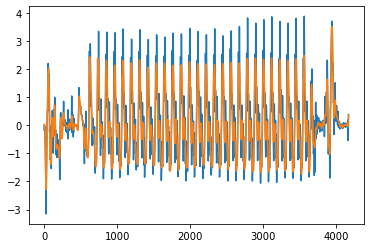

In [131]:
plt.plot(gyr[:,0])
plt.plot(filter_gyr[:,0])

In [132]:
def cut_data(acc_filt, gyr_filt, freq):
    acc_abs = np.linalg.norm(acc_filt,axis=1)
    
    peaks, _ = signal.find_peaks(acc_abs,height=11, distance=freq/2)
    diff_peaks =np.diff(peaks)
    gap1  = np.argmax(diff_peaks[:10])
    gap2  = np.argmax(diff_peaks[-10:])
    gap2  = int(gap2 + np.shape(diff_peaks)-10)
    
    acc_cut = acc_filt[peaks[gap1+1]:peaks[gap2],:]
    gyr_cut = gyr_filt[peaks[gap1+1]:peaks[gap2],:]
    
    return acc_cut, gyr_cut

In [133]:
acc_cut, gyr_cut = cut_data(filter_acc,filter_gyr,sampling_frequency)

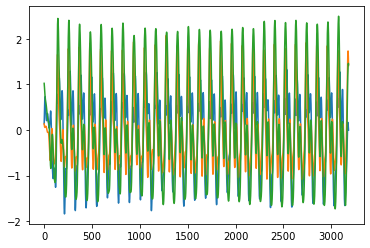

In [134]:
plt.plot(gyr_cut[:,1])
plt.plot(gyr_cut[:,2])
plt.plot(gyr_cut[:,0])

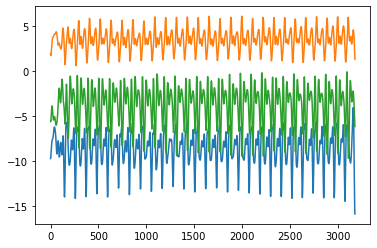

In [135]:
plt.plot(acc_cut[:,1])
plt.plot(acc_cut[:,2])
plt.plot(acc_cut[:,0])

In [136]:
l
if l == 0:
    lb = np.zeros(len(acc_cut), dtype=int)
else:
    lb = np.ones(len(acc_cut),dtype=int)

In [137]:
columns = ['Acceleration x (m/s^2)', 'Acceleration y (m/s^2)', 'Acceleration z (m/s^2)', 'Gyroscope x (rad/s)', 'Gyroscope y (rad/s)', 'Gyroscope z (rad/s)']
df = pd.DataFrame(columns = columns)
df['Acceleration x (m/s^2)'] = acc_cut[:,0]
df['Acceleration y (m/s^2)'] = acc_cut[:,1]
df['Acceleration z (m/s^2)'] = acc_cut[:,2]
df['Gyroscope x (rad/s)'] = gyr_cut[:,0]
df['Gyroscope y (rad/s)'] = gyr_cut[:,1]
df['Gyroscope z (rad/s)'] = gyr_cut[:,2]
df['Label'] = lb
df

,Acceleration x (m/s^2),Acceleration y (m/s^2),Acceleration z (m/s^2),Gyroscope x (rad/s),Gyroscope y (rad/s),Gyroscope z (rad/s),Label
0,-5.583193,-9.728411,1.917144,1.021826,0.134112,0.132799,0
1,-5.624768,-9.697511,1.809307,1.000221,0.235763,0.112505,0
2,-5.621751,-9.624755,1.743460,0.971960,0.335072,0.095347,0
3,-5.573999,-9.515802,1.719029,0.938927,0.428420,0.081476,0
4,-5.483887,-9.377529,1.733690,0.902973,0.512697,0.070858,0
...,...,...,...,...,...,...,...
3176,-5.027874,-14.048323,2.469811,1.428479,0.121161,1.713564,0
3177,-5.319789,-14.791542,2.174510,1.450924,0.089363,1.671359,0
3178,-5.613720,-15.356707,1.876301,1.459009,0.055699,1.605481,0
3179,-5.902398,-15.723290,1.580953,1.453229,0.024440,1.518068,0


In [49]:
#data = pd.DataFrame()
#data = data.append(df, ignore_index = True)
#data

data = pd.read_csv('data.csv')
data

,X (m/s^2),Y (m/s^2),Z (m/s^2),X (rad/s),Y (rad/s),Z (rad/s),Gait,Subject,Label
0,-0.510382,10.091575,-0.138935,-0.264144,0.290234,-0.057365,impaired,150,0
1,-0.646829,9.771206,0.019439,-0.244282,0.223429,-0.048109,impaired,150,0
2,-0.781829,9.477364,0.164959,-0.226800,0.157773,-0.039301,impaired,150,0
3,-0.914405,9.228943,0.283991,-0.212506,0.093439,-0.031251,impaired,150,0
4,-1.042008,9.042656,0.368109,-0.201931,0.030618,-0.024181,impaired,150,0
...,...,...,...,...,...,...,...,...,...
94795,-2.434576,-8.295600,4.059749,-1.764167,-1.603143,-0.873110,walking,259,1
94796,-2.357589,-8.346248,4.120938,-1.763322,-1.498327,-0.818496,walking,259,1
94797,-2.314741,-8.358373,4.151912,-1.741424,-1.378397,-0.769810,walking,259,1
94798,-2.304032,-8.338493,4.158702,-1.703418,-1.252735,-0.728979,walking,259,1


In [87]:
x = data[['X (m/s^2)', 'Y (m/s^2)', 'Z (m/s^2)', 'X (rad/s)', 'Y (rad/s)', 'Z (rad/s)']]
y = data['Label']


In [88]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size = 0.1, random_state = 0)

X_train.shape

(85320, 6)

In [89]:
scaler = StandardScaler()
x = scaler.fit_transform(x)

scaled_x = pd.DataFrame(data = x, columns = ['X (m/s^2)', 'Y (m/s^2)', 'Z (m/s^2)', 'X (rad/s)', 'Y (rad/s)', 'Z (rad/s)'])
#scaled_x['Label'] = y.values

print(scaled_x)
print(scaled_x.shape)
print(y.shape)

       X (m/s^2)  Y (m/s^2)  Z (m/s^2)  X (rad/s)  Y (rad/s)  Z (rad/s)
0       0.125854   1.136568   0.062058  -0.390122   0.386933  -0.077228
1       0.081465   1.102915   0.118619  -0.362428   0.297753  -0.064656
2       0.037546   1.072050   0.170589  -0.338052   0.210107  -0.052691
3      -0.005584   1.045955   0.213099  -0.318121   0.124226  -0.041758
4      -0.047097   1.026387   0.243140  -0.303375   0.040364  -0.032154
...          ...        ...        ...        ...        ...        ...
94795  -0.500133  -0.794862   1.561545  -2.481693  -2.140591  -1.185257
94796  -0.475087  -0.800182   1.583398  -2.480515  -2.000670  -1.111075
94797  -0.461148  -0.801456   1.594460  -2.449981  -1.840572  -1.044944
94798  -0.457664  -0.799367   1.596885  -2.396987  -1.672821  -0.989483
94799  -0.463347  -0.794557   1.594025  -2.329794  -1.509602  -0.945554

[94800 rows x 6 columns]
(94800, 6)
(94800,)


In [90]:
p = scaled_x.iloc[:,:3]
q = scaled_x.iloc[:,3:]
print(p)
print(q)

       X (m/s^2)  Y (m/s^2)  Z (m/s^2)
0       0.125854   1.136568   0.062058
1       0.081465   1.102915   0.118619
2       0.037546   1.072050   0.170589
3      -0.005584   1.045955   0.213099
4      -0.047097   1.026387   0.243140
...          ...        ...        ...
94795  -0.500133  -0.794862   1.561545
94796  -0.475087  -0.800182   1.583398
94797  -0.461148  -0.801456   1.594460
94798  -0.457664  -0.799367   1.596885
94799  -0.463347  -0.794557   1.594025

[94800 rows x 3 columns]
       X (rad/s)  Y (rad/s)  Z (rad/s)
0      -0.390122   0.386933  -0.077228
1      -0.362428   0.297753  -0.064656
2      -0.338052   0.210107  -0.052691
3      -0.318121   0.124226  -0.041758
4      -0.303375   0.040364  -0.032154
...          ...        ...        ...
94795  -2.481693  -2.140591  -1.185257
94796  -2.480515  -2.000670  -1.111075
94797  -2.449981  -1.840572  -1.044944
94798  -2.396987  -1.672821  -0.989483
94799  -2.329794  -1.509602  -0.945554

[94800 rows x 3 columns]


In [91]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 1)
a = pca.fit_transform(p)
print(a)

[[-0.75449788]
 [-0.67903996]
 [-0.60862096]
 ...
 [ 1.74689098]
 [ 1.74586486]
 [ 1.74283768]]


In [92]:
g = pca.fit_transform(q)
print(g)
print(type(g))

[[-0.04133233]
 [-0.00381197]
 [ 0.03444312]
 ...
 [ 2.83016549]
 [ 2.66572424]
 [ 2.50621313]]
<class 'numpy.ndarray'>


In [93]:
t = np.concatenate([a,g], axis = 1)
print(t)

[[-0.75449788 -0.04133233]
 [-0.67903996 -0.00381197]
 [-0.60862096  0.03444312]
 ...
 [ 1.74689098  2.83016549]
 [ 1.74586486  2.66572424]
 [ 1.74283768  2.50621313]]


In [94]:
classifier = Sequential()
classifier.add(Dense(500, activation='relu', input_dim=6))
classifier.add(Dense(250, activation='relu'))
classifier.add(Dense(1, activation='sigmoid'))
classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['Accuracy'])

In [95]:
classifier.fit(X_train, Y_train, epochs=20)

Epoch 1/20
2667/2667 [==============================] - 13s 4ms/step - loss: 0.5596 - Accuracy: 0.6853
Epoch 2/20
2667/2667 [==============================] - 14s 5ms/step - loss: 0.4425 - Accuracy: 0.7775
Epoch 3/20
2667/2667 [==============================] - 13s 5ms/step - loss: 0.3792 - Accuracy: 0.8172
Epoch 4/20
2667/2667 [==============================] - 14s 5ms/step - loss: 0.3405 - Accuracy: 0.8419
Epoch 5/20
2667/2667 [==============================] - 14s 5ms/step - loss: 0.3129 - Accuracy: 0.8569
Epoch 6/20
2667/2667 [==============================] - 13s 5ms/step - loss: 0.2925 - Accuracy: 0.8671
Epoch 7/20
2667/2667 [==============================] - 14s 5ms/step - loss: 0.2759 - Accuracy: 0.8764
Epoch 8/20
2667/2667 [==============================] - 14s 5ms/step - loss: 0.2609 - Accuracy: 0.8827
Epoch 9/20
2667/2667 [==============================] - 15s 5ms/step - loss: 0.2524 - Accuracy: 0.8876
Epoch 10/20
2667/2667 [==============================] - 13s 5ms/step - l

In [97]:
pred_test= classifier.predict(X_test)
scores2 = classifier.evaluate(X_test, Y_test, verbose=0)
print(pred_test)
print(scores2[1])

[[1.        ]
 [0.00137156]
 [0.9999957 ]
 ...
 [1.        ]
 [0.9999976 ]
 [0.96059763]]
0.905907154083252


In [60]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
print(sklearn.__version__)

1.0.1


In [61]:
def built_classifier():
    classifier = Sequential()
    classifier.add(Dense(100, activation='relu', input_dim=6))
    classifier.add(Dense(50, activation='relu'))
    classifier.add(Dense(1, activation='sigmoid'))
    classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['Accuracy'])
    return classifier

In [62]:
classifier = KerasClassifier(build_fn = built_classifier, batch_size = 100, epochs = 100)


C:\Users\nikjo\AppData\Local\Temp/ipykernel_8276/3979179367.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  classifier = KerasClassifier(build_fn = built_classifier, batch_size = 100, epochs = 100)


In [63]:
accuracy = cross_val_score(estimator=classifier, X = scaled_x, y = y, cv=10, scoring='accuracy')


Epoch 1/100
854/854 [==============================] - 1s 845us/step - loss: 0.5592 - Accuracy: 0.6953
Epoch 2/100
854/854 [==============================] - 1s 824us/step - loss: 0.4662 - Accuracy: 0.7706
Epoch 3/100
854/854 [==============================] - 1s 867us/step - loss: 0.4208 - Accuracy: 0.8008
Epoch 4/100
854/854 [==============================] - 1s 913us/step - loss: 0.3935 - Accuracy: 0.8165
Epoch 5/100
854/854 [==============================] - 1s 868us/step - loss: 0.3723 - Accuracy: 0.8285
Epoch 6/100
854/854 [==============================] - 1s 826us/step - loss: 0.3569 - Accuracy: 0.8381
Epoch 7/100
854/854 [==============================] - 1s 883us/step - loss: 0.3436 - Accuracy: 0.8462
Epoch 8/100
854/854 [==============================] - 1s 848us/step - loss: 0.3324 - Accuracy: 0.8523
Epoch 9/100
854/854 [==============================] - 1s 896us/step - loss: 0.3224 - Accuracy: 0.8576
Epoch 10/100
854/854 [==============================] - 1s 889us/step - l

854/854 [==============================] - 1s 815us/step - loss: 0.1919 - Accuracy: 0.9196
Epoch 80/100
854/854 [==============================] - 1s 830us/step - loss: 0.1894 - Accuracy: 0.9205
Epoch 81/100
854/854 [==============================] - 1s 828us/step - loss: 0.1905 - Accuracy: 0.9203
Epoch 82/100
854/854 [==============================] - 1s 816us/step - loss: 0.1874 - Accuracy: 0.9219
Epoch 83/100
854/854 [==============================] - 1s 818us/step - loss: 0.1872 - Accuracy: 0.9221
Epoch 84/100
854/854 [==============================] - 1s 847us/step - loss: 0.1882 - Accuracy: 0.92100s - loss: 0.1860 - Accu
Epoch 85/100
854/854 [==============================] - 1s 797us/step - loss: 0.1872 - Accuracy: 0.9225
Epoch 86/100
854/854 [==============================] - 1s 883us/step - loss: 0.1853 - Accuracy: 0.9227
Epoch 87/100
854/854 [==============================] - 1s 888us/step - loss: 0.1880 - Accuracy: 0.9218
Epoch 88/100
854/854 [==============================]

854/854 [==============================] - 1s 900us/step - loss: 0.2312 - Accuracy: 0.8987
Epoch 58/100
854/854 [==============================] - 1s 937us/step - loss: 0.2271 - Accuracy: 0.9013
Epoch 59/100
854/854 [==============================] - 1s 827us/step - loss: 0.2283 - Accuracy: 0.9012
Epoch 60/100
854/854 [==============================] - 1s 891us/step - loss: 0.2282 - Accuracy: 0.9002
Epoch 61/100
854/854 [==============================] - 1s 904us/step - loss: 0.2248 - Accuracy: 0.9021
Epoch 62/100
854/854 [==============================] - 1s 881us/step - loss: 0.2277 - Accuracy: 0.9011
Epoch 63/100
854/854 [==============================] - 1s 857us/step - loss: 0.2252 - Accuracy: 0.9013
Epoch 64/100
854/854 [==============================] - 1s 874us/step - loss: 0.2241 - Accuracy: 0.9028
Epoch 65/100
854/854 [==============================] - 1s 882us/step - loss: 0.2243 - Accuracy: 0.9022
Epoch 66/100
854/854 [==============================] - 1s 863us/step - loss:

854/854 [==============================] - 1s 842us/step - loss: 0.2407 - Accuracy: 0.8952
Epoch 36/100
854/854 [==============================] - 1s 856us/step - loss: 0.2394 - Accuracy: 0.8955
Epoch 37/100
854/854 [==============================] - 1s 897us/step - loss: 0.2391 - Accuracy: 0.8954
Epoch 38/100
854/854 [==============================] - 1s 909us/step - loss: 0.2354 - Accuracy: 0.8978
Epoch 39/100
854/854 [==============================] - 1s 870us/step - loss: 0.2338 - Accuracy: 0.8978
Epoch 40/100
854/854 [==============================] - 1s 859us/step - loss: 0.2334 - Accuracy: 0.8981
Epoch 41/100
854/854 [==============================] - 1s 932us/step - loss: 0.2327 - Accuracy: 0.8978
Epoch 42/100
854/854 [==============================] - 1s 868us/step - loss: 0.2321 - Accuracy: 0.8980
Epoch 43/100
854/854 [==============================] - 1s 854us/step - loss: 0.2301 - Accuracy: 0.8990
Epoch 44/100
854/854 [==============================] - 1s 883us/step - loss:

854/854 [==============================] - 1s 839us/step - loss: 0.3068 - Accuracy: 0.8603
Epoch 14/100
854/854 [==============================] - 1s 977us/step - loss: 0.3029 - Accuracy: 0.8632
Epoch 15/100
854/854 [==============================] - 1s 922us/step - loss: 0.2981 - Accuracy: 0.8655
Epoch 16/100
854/854 [==============================] - 1s 915us/step - loss: 0.2920 - Accuracy: 0.8680
Epoch 17/100
854/854 [==============================] - 1s 854us/step - loss: 0.2890 - Accuracy: 0.8703
Epoch 18/100
854/854 [==============================] - 1s 949us/step - loss: 0.2852 - Accuracy: 0.8730
Epoch 19/100
854/854 [==============================] - 1s 959us/step - loss: 0.2802 - Accuracy: 0.8759
Epoch 20/100
854/854 [==============================] - 1s 892us/step - loss: 0.2775 - Accuracy: 0.8758
Epoch 21/100
854/854 [==============================] - 1s 891us/step - loss: 0.2751 - Accuracy: 0.8768
Epoch 22/100
854/854 [==============================] - 1s 986us/step - loss:

854/854 [==============================] - 1s 783us/step - loss: 0.1999 - Accuracy: 0.9154
Epoch 92/100
854/854 [==============================] - 1s 776us/step - loss: 0.1989 - Accuracy: 0.9148
Epoch 93/100
854/854 [==============================] - 1s 795us/step - loss: 0.1991 - Accuracy: 0.9147
Epoch 94/100
854/854 [==============================] - 1s 814us/step - loss: 0.1982 - Accuracy: 0.9153
Epoch 95/100
854/854 [==============================] - 1s 784us/step - loss: 0.1981 - Accuracy: 0.9155
Epoch 96/100
854/854 [==============================] - 1s 780us/step - loss: 0.1983 - Accuracy: 0.9159
Epoch 97/100
854/854 [==============================] - 1s 791us/step - loss: 0.1969 - Accuracy: 0.9153
Epoch 98/100
854/854 [==============================] - 1s 803us/step - loss: 0.1967 - Accuracy: 0.9157
Epoch 99/100
854/854 [==============================] - 1s 782us/step - loss: 0.1965 - Accuracy: 0.9161
Epoch 100/100
854/854 [==============================] - 1s 1ms/step - loss: 

854/854 [==============================] - 1s 823us/step - loss: 0.2261 - Accuracy: 0.9014
Epoch 70/100
854/854 [==============================] - 1s 793us/step - loss: 0.2244 - Accuracy: 0.9018
Epoch 71/100
854/854 [==============================] - 1s 792us/step - loss: 0.2260 - Accuracy: 0.9020
Epoch 72/100
854/854 [==============================] - 1s 793us/step - loss: 0.2243 - Accuracy: 0.9030
Epoch 73/100
854/854 [==============================] - 1s 802us/step - loss: 0.2240 - Accuracy: 0.9035
Epoch 74/100
854/854 [==============================] - 1s 795us/step - loss: 0.2226 - Accuracy: 0.9037
Epoch 75/100
854/854 [==============================] - 1s 841us/step - loss: 0.2226 - Accuracy: 0.9035
Epoch 76/100
854/854 [==============================] - 1s 811us/step - loss: 0.2208 - Accuracy: 0.9038
Epoch 77/100
854/854 [==============================] - 1s 775us/step - loss: 0.2201 - Accuracy: 0.9055
Epoch 78/100
854/854 [==============================] - 1s 812us/step - loss:

Epoch 48/100
854/854 [==============================] - 1s 833us/step - loss: 0.2564 - Accuracy: 0.8873
Epoch 49/100
854/854 [==============================] - 1s 839us/step - loss: 0.2548 - Accuracy: 0.8874
Epoch 50/100
854/854 [==============================] - 1s 822us/step - loss: 0.2535 - Accuracy: 0.8893
Epoch 51/100
854/854 [==============================] - 1s 796us/step - loss: 0.2520 - Accuracy: 0.8892
Epoch 52/100
854/854 [==============================] - 1s 751us/step - loss: 0.2524 - Accuracy: 0.8888
Epoch 53/100
854/854 [==============================] - 1s 823us/step - loss: 0.2518 - Accuracy: 0.8893
Epoch 54/100
854/854 [==============================] - 1s 894us/step - loss: 0.2533 - Accuracy: 0.8892
Epoch 55/100
854/854 [==============================] - 1s 852us/step - loss: 0.2487 - Accuracy: 0.8906
Epoch 56/100
854/854 [==============================] - 1s 895us/step - loss: 0.2484 - Accuracy: 0.89120s - loss: 0.2474 
Epoch 57/100
854/854 [========================

854/854 [==============================] - 1s 806us/step - loss: 0.2957 - Accuracy: 0.8675
Epoch 27/100
854/854 [==============================] - 1s 772us/step - loss: 0.2939 - Accuracy: 0.8692
Epoch 28/100
854/854 [==============================] - 1s 781us/step - loss: 0.2908 - Accuracy: 0.8705
Epoch 29/100
854/854 [==============================] - 1s 830us/step - loss: 0.2907 - Accuracy: 0.8703
Epoch 30/100
854/854 [==============================] - 1s 798us/step - loss: 0.2881 - Accuracy: 0.8733
Epoch 31/100
854/854 [==============================] - 1s 800us/step - loss: 0.2852 - Accuracy: 0.8721
Epoch 32/100
854/854 [==============================] - 1s 776us/step - loss: 0.2829 - Accuracy: 0.8737
Epoch 33/100
854/854 [==============================] - 1s 807us/step - loss: 0.2822 - Accuracy: 0.8747
Epoch 34/100
854/854 [==============================] - 1s 786us/step - loss: 0.2799 - Accuracy: 0.8745
Epoch 35/100
854/854 [==============================] - 1s 803us/step - loss:

854/854 [==============================] - 1s 867us/step - loss: 0.4083 - Accuracy: 0.8024
Epoch 5/100
854/854 [==============================] - 1s 896us/step - loss: 0.3875 - Accuracy: 0.8161
Epoch 6/100
854/854 [==============================] - 1s 825us/step - loss: 0.3699 - Accuracy: 0.8278
Epoch 7/100
854/854 [==============================] - 1s 770us/step - loss: 0.3559 - Accuracy: 0.8357
Epoch 8/100
854/854 [==============================] - 1s 802us/step - loss: 0.3443 - Accuracy: 0.8426
Epoch 9/100
854/854 [==============================] - 1s 853us/step - loss: 0.3337 - Accuracy: 0.8486
Epoch 10/100
854/854 [==============================] - 1s 841us/step - loss: 0.3247 - Accuracy: 0.8546
Epoch 11/100
854/854 [==============================] - 1s 840us/step - loss: 0.3173 - Accuracy: 0.8584
Epoch 12/100
854/854 [==============================] - 1s 895us/step - loss: 0.3117 - Accuracy: 0.8605
Epoch 13/100
854/854 [==============================] - 1s 851us/step - loss: 0.30

854/854 [==============================] - 1s 856us/step - loss: 0.2070 - Accuracy: 0.9109
Epoch 83/100
854/854 [==============================] - 1s 892us/step - loss: 0.2060 - Accuracy: 0.9106
Epoch 84/100
854/854 [==============================] - 1s 893us/step - loss: 0.2067 - Accuracy: 0.9107
Epoch 85/100
854/854 [==============================] - 1s 792us/step - loss: 0.2067 - Accuracy: 0.9102
Epoch 86/100
854/854 [==============================] - 1s 861us/step - loss: 0.2034 - Accuracy: 0.9114
Epoch 87/100
854/854 [==============================] - 1s 769us/step - loss: 0.2040 - Accuracy: 0.9123
Epoch 88/100
854/854 [==============================] - 1s 766us/step - loss: 0.2024 - Accuracy: 0.9119
Epoch 89/100
854/854 [==============================] - 1s 925us/step - loss: 0.2029 - Accuracy: 0.9123
Epoch 90/100
854/854 [==============================] - 1s 844us/step - loss: 0.2027 - Accuracy: 0.9124
Epoch 91/100
854/854 [==============================] - 1s 822us/step - loss:

854/854 [==============================] - 1s 818us/step - loss: 0.2511 - Accuracy: 0.8898
Epoch 61/100
854/854 [==============================] - 1s 781us/step - loss: 0.2507 - Accuracy: 0.8894
Epoch 62/100
854/854 [==============================] - 1s 884us/step - loss: 0.2513 - Accuracy: 0.8897
Epoch 63/100
854/854 [==============================] - 1s 911us/step - loss: 0.2499 - Accuracy: 0.8900
Epoch 64/100
854/854 [==============================] - 1s 829us/step - loss: 0.2498 - Accuracy: 0.8898
Epoch 65/100
854/854 [==============================] - 1s 834us/step - loss: 0.2479 - Accuracy: 0.8905
Epoch 66/100
854/854 [==============================] - 1s 867us/step - loss: 0.2471 - Accuracy: 0.8918
Epoch 67/100
854/854 [==============================] - 1s 848us/step - loss: 0.2482 - Accuracy: 0.8907
Epoch 68/100
854/854 [==============================] - 1s 870us/step - loss: 0.2459 - Accuracy: 0.8910
Epoch 69/100
854/854 [==============================] - 1s 851us/step - loss:

854/854 [==============================] - 1s 947us/step - loss: 0.2594 - Accuracy: 0.88560s - loss: 0
Epoch 39/100
854/854 [==============================] - 1s 812us/step - loss: 0.2571 - Accuracy: 0.8869
Epoch 40/100
854/854 [==============================] - 1s 796us/step - loss: 0.2553 - Accuracy: 0.8870
Epoch 41/100
854/854 [==============================] - 1s 928us/step - loss: 0.2544 - Accuracy: 0.8885
Epoch 42/100
854/854 [==============================] - 1s 921us/step - loss: 0.2534 - Accuracy: 0.8887
Epoch 43/100
854/854 [==============================] - 1s 891us/step - loss: 0.2543 - Accuracy: 0.8890
Epoch 44/100
854/854 [==============================] - 1s 831us/step - loss: 0.2515 - Accuracy: 0.8900
Epoch 45/100
854/854 [==============================] - 1s 1ms/step - loss: 0.2482 - Accuracy: 0.8911
Epoch 46/100
854/854 [==============================] - 1s 909us/step - loss: 0.2489 - Accuracy: 0.8912
Epoch 47/100
854/854 [==============================] - 1s 982us/st

In [64]:
print(accuracy)
print(accuracy.mean())

[0.48808017 0.67299578 0.46455696 0.57246835 0.6878692  0.69831224
 0.73818565 0.68987342 0.69957806 0.64736287]
0.6359282700421941


In [98]:
def built_classifier2():
    classifier2 = Sequential()
    classifier2.add(Dense(20, activation='relu', input_dim=2))
    classifier2.add(Dense(10, activation='relu'))
    classifier2.add(Dense(1, activation='sigmoid'))
    classifier2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['Accuracy'])
    return classifier2

In [99]:
classifier2 = KerasClassifier(build_fn = built_classifier2, batch_size = 20, epochs = 100)


C:\Users\nikjo\AppData\Local\Temp/ipykernel_8276/1901883460.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  classifier2 = KerasClassifier(build_fn = built_classifier2, batch_size = 20, epochs = 100)


In [100]:
accuracy2 = cross_val_score(estimator=classifier2, X = t, y = y, cv=2, scoring='accuracy')

Epoch 1/100
2370/2370 [==============================] - 7s 3ms/step - loss: 0.5869 - Accuracy: 0.6627: 0s - loss: 0.5872 - Accura
Epoch 2/100
2370/2370 [==============================] - 7s 3ms/step - loss: 0.5632 - Accuracy: 0.6807
Epoch 3/100
2370/2370 [==============================] - 7s 3ms/step - loss: 0.5574 - Accuracy: 0.6872
Epoch 4/100
2370/2370 [==============================] - 6s 3ms/step - loss: 0.5531 - Accuracy: 0.6920
Epoch 5/100
2370/2370 [==============================] - 6s 3ms/step - loss: 0.5510 - Accuracy: 0.6938
Epoch 6/100
2370/2370 [==============================] - 6s 3ms/step - loss: 0.5489 - Accuracy: 0.6947
Epoch 7/100
2370/2370 [==============================] - 6s 3ms/step - loss: 0.5476 - Accuracy: 0.6958
Epoch 8/100
2370/2370 [==============================] - 7s 3ms/step - loss: 0.5466 - Accuracy: 0.6961
Epoch 9/100
2370/2370 [==============================] - 7s 3ms/step - loss: 0.5454 - Accuracy: 0.6986
Epoch 10/100
2370/2370 [=====================

2370/2370 [==============================] - 7s 3ms/step - loss: 0.5237 - Accuracy: 0.7139
Epoch 79/100
2370/2370 [==============================] - 8s 3ms/step - loss: 0.5235 - Accuracy: 0.7146
Epoch 80/100
2370/2370 [==============================] - 7s 3ms/step - loss: 0.5234 - Accuracy: 0.7150
Epoch 81/100
2370/2370 [==============================] - 8s 3ms/step - loss: 0.5230 - Accuracy: 0.7150
Epoch 82/100
2370/2370 [==============================] - 7s 3ms/step - loss: 0.5230 - Accuracy: 0.7142
Epoch 83/100
2370/2370 [==============================] - 6s 3ms/step - loss: 0.5231 - Accuracy: 0.7144
Epoch 84/100
2370/2370 [==============================] - 8s 3ms/step - loss: 0.5231 - Accuracy: 0.7154
Epoch 85/100
2370/2370 [==============================] - 8s 4ms/step - loss: 0.5229 - Accuracy: 0.7154
Epoch 86/100
2370/2370 [==============================] - 8s 3ms/step - loss: 0.5226 - Accuracy: 0.7158: 0s - loss: 0.5226 - Ac
Epoch 87/100
2370/2370 [=============================

2370/2370 [==============================] - 2s 771us/step - loss: 0.6468 - Accuracy: 0.61350s - loss:
Epoch 51/100
2370/2370 [==============================] - 2s 765us/step - loss: 0.6463 - Accuracy: 0.6114
Epoch 52/100
2370/2370 [==============================] - 2s 763us/step - loss: 0.6463 - Accuracy: 0.6137
Epoch 53/100
2370/2370 [==============================] - 2s 771us/step - loss: 0.6455 - Accuracy: 0.6142
Epoch 54/100
2370/2370 [==============================] - 2s 771us/step - loss: 0.6456 - Accuracy: 0.6137
Epoch 55/100
2370/2370 [==============================] - 2s 775us/step - loss: 0.6447 - Accuracy: 0.61501s - loss: 0.6453 - Accuracy
Epoch 56/100
2370/2370 [==============================] - 2s 779us/step - loss: 0.6447 - Accuracy: 0.6166
Epoch 57/100
2370/2370 [==============================] - 2s 776us/step - loss: 0.6447 - Accuracy: 0.61660s - loss: 0.6449 - Accuracy:  - ETA: 0s - loss: 0.6447 - Accura
Epoch 58/100
2370/2370 [==============================] - 2s 74

In [85]:
print(accuracy2)
print(accuracy2.mean())

[0.47632911 0.41879747]
0.44756329113924054


In [86]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=200)
#knn.fit(X_train,Y_train)
final= cross_val_score(knn, t, y, cv=10, scoring='accuracy').mean()
print(final)

0.5989662447257385
